<a href="https://colab.research.google.com/github/VStee1e/EEG-Location-Prediction/blob/main/Revised_FastICA_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install libraries and imports

In [1]:
!pip install librosa
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 45.2 MB/s eta 0:00:00


In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from IPython.display import Audio
import mne
import scipy as sp
import scipy.sparse as sparse
import random
from scipy.signal import stft, istft
from sklearn.decomposition import FastICA
from scipy.stats import zscore
import os.path

In [3]:
def make_specgram(ys,sfreq,names):
    hop_length = 1024

    fig, axs = plt.subplots(nrows=len(ys), ncols=1, sharex=True, figsize=(4,2*len(ys)))
    try:
        axs[0]
    except:
        axs = list([axs])

    for i,y in enumerate(ys):
        print(y.shape)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                                    ref=np.max)
        img = librosa.display.specshow(D, y_axis='log', sr=sfreq, hop_length=hop_length,
                                x_axis='time', ax=axs[i])
        axs[i].set(title=names[i])
        axs[i].label_outer()
    fig.suptitle('Log-frequency power spectrogram', fontsize=12)
    fig.colorbar(img, ax=axs, format="%+2.f dB")
    return

Create highpass filter

In [4]:
def hpfilter_and_grab_windows(x,sfreq,cutoff=0.5,order=4,start_time=0,end_time=None,window_length_real_time=1):
    """
    High-pass filters signal x and returns non-overlapping windows of length window_length_real_time
    """
    from scipy.signal import butter, filtfilt

    #high pass filter
    nyq = 0.5 * sfreq
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    x_filt = filtfilt(b, a, x)

    #grab windows
    window_length = int(window_length_real_time * sfreq)
    start_index = int(start_time * sfreq)
    if end_time is None:
        end_index = len(x)  # Set end_index to the end of the data
    else:
        end_index = int(end_time * sfreq)

    # Check if the calculated indices are within the bounds of the data
    if start_index < 0 or end_index > len(x_filt):
        raise ValueError("Start or end time is out of bounds for the given data.")

    sig_len = end_index - start_index
    n_wins = int(sig_len//window_length)

    # Handle the case where the signal length is not a multiple of the window length
    if sig_len % window_length != 0:
        print("Warning: Signal length is not a multiple of window length. Truncating the end.")
        end_index = start_index + n_wins * window_length

    # Reshape the data into windows
    X = x_filt[start_index:end_index].reshape(window_length, n_wins, order='F')

    return X

    # if end_time is None:
    #     end_time = x.shape[0]*sfreq
    # duration = end_time-start_time
    # window_length = int(np.ceil(window_length_real_time*sfreq))
    # b, a = scipy.signal.butter(order,cutoff,fs=sfreq,btype='highpass')
    # x = scipy.signal.lfilter(b, a, x)
    # start_index = int(np.ceil(start_time*sfreq))
    # n_wins = int(np.floor(end_time*sfreq/window_length))

    # end_index = start_index + n_wins*window_length
    # sig_len = end_index - start_index

    # X = x[start_index:end_index].reshape(window_length,n_wins,order='F')
    # return X

Signal anlysis and synthesis

In [5]:
def sp_signal_analysis(x, win_len, overlap=0.5, win_choice=lambda L: np.hanning(L), n_fft=None):
    if n_fft is None:
        n_fft = win_len
    rfft_freq, win_times, x_rfft = stft(x,fs=2*np.pi, nperseg=win_len,noverlap=int(overlap*win_len),nfft=n_fft,return_onesided=True,axis=0)
    return np.moveaxis(x_rfft,-1,1), rfft_freq

def sp_signal_synthesis(x_rfft, win_len, overlap=0.5, win_choice=lambda L: np.hanning(L), n_fft=None):
    if n_fft is None:
        n_fft = win_len
    times, x_syn = istft(x_rfft,fs=2*np.pi,nperseg=win_len,noverlap=int(overlap*win_len),nfft=n_fft,input_onesided=True,freq_axis=0,time_axis=1)
    return x_syn

Load data

In [6]:
fn = 'cue_subj_01_chunked.npz'
raw_traces = np.load(fn, allow_pickle=True)
fs = 512
assert(os.path.isfile(fn))
filenames = [fn]
scalings = [1e-4]
info = mne.create_info(63, fs, ch_types='eeg')
# print(y)
raw_traces['icaact'].shape
# for i,filename in enumerate(filenames):
#     raw_traces.append(mne.io.RawArray(data=data, info=info))
#     hour_start, minute_start, second_start = 0,2,2
#     start_time = hour_start*60*60+minute_start*60+second_start

#     duration = 6

(131, 63, 7680)

Multi-channel highpass fiter

In [7]:
def hpfilter_multichannel(X,sfreq):
    return X

Grab a shortened window of the signal to analyze

In [8]:
def get_window_across_channels_filter(raw_sig,sfreq,start_time,end_time,cutoff,order):
    # Check if raw_sig is an npz file and load it if so
    if isinstance(raw_sig, np.lib.npyio.NpzFile):
        raw_data = raw_sig['icaact']  # Assuming 'icaact' key holds the actual data
        raw_data = raw_data[0]
        ch_names = int(len(raw_sig['labels']))  # Assuming 'labels' key holds channel names
        # Create a dummy MNE Raw object (replace with actual info if available)
        # info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
        info = mne.create_info(ch_names=[str(i) for i in range(ch_names)], sfreq=sfreq, ch_types='eeg')
        raw_sig = mne.io.RawArray(data=raw_data, info=info)
    else:
        ch_names = raw_sig.ch_names  # Get channel names if it's already an MNE Raw object

    if end_time is None:
        end_time = raw_sig.times[-1]  # Use the end time from the Raw object

    t_idx = raw_sig.time_as_index([start_time,end_time])
    X, times = raw_sig[:, t_idx[0]:t_idx[1]]
    X = X.T

    b, a = scipy.signal.butter(order,cutoff,fs=sfreq,btype='highpass')
    X_filtered = scipy.signal.lfilter(b, a, X,axis=0)

    return X_filtered, ch_names



    # ch_names = raw_sig['labels']
    # if end_time is None:
    #     end_time = raw_sig[ch_names[0]][0].shape[0]*sfreq

    # t_idx = raw_sig.time_as_index([start_time,end_time])
    # X, times = raw_sig[:, t_idx[0]:t_idx[1]]
    # X = X.T

    # b, a = scipy.signal.butter(order,cutoff,fs=sfreq,btype='highpass')
    # X_filtered = scipy.signal.lfilter(b, a, X,axis=0)

    # return X_filtered, ch_names

Define channels for analysis

In [9]:
hour_start, minute_start, second_start = 0,1,0
start_time = hour_start*60*60+minute_start*60+second_start
end_time = start_time+5*60

signal = raw_traces['icaact']
sfreq = fs
fs_1 = sfreq
raw_traces
X_1, ch_names_1 = get_window_across_channels_filter(raw_sig=[raw_traces][0], sfreq=sfreq,start_time=start_time,end_time=end_time, cutoff=0.5, order=4)
# signal = raw_traces[2]
# sfreq = signal.info["sfreq"]
# fs_2 = sfreq
# X_2, ch_names_2 = get_window_across_channels_filter(signal,sfreq,start_time,end_time)

Creating RawArray with float64 data, n_channels=63, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    14.998 secs
Ready.


Apply highpass filter to defined signals

In [10]:
window_length_real_time = 1  # window length in s
n_windows = int(500) # non overlapping
hp_cutoff = 0.5
hp_order = 4
overlap = 0.5


hour_start, minute_start, second_start = 0,1,0
start_time = hour_start*60*60+minute_start*60+second_start
end_time = start_time+n_windows*window_length_real_time

signal,ch_i,data_name = raw_traces['icaact'], 2, 'cue_emotion'
signal_length_seconds = signal.shape[-1] / sfreq
end_time = min(start_time + n_windows * window_length_real_time, signal_length_seconds)

#signal,ch_i = raw_traces[2], 5
sfreq, ch_name = sfreq, raw_traces['labels']
fs_1 = sfreq
# X_1 = hpfilter_and_grab_windows([ch_name][0].squeeze(),sfreq,hp_cutoff,hp_order,start_time,end_time,window_length_real_time)
X_1 = hpfilter_and_grab_windows(signal[:, ch_i, :].squeeze(), sfreq, hp_cutoff, hp_order, start_time=0, end_time=None, window_length_real_time=1)

# signal,ch_i = raw_traces[2], 5
# sfreq, ch_name = sfreq, signal.info['ch_names'][ch_i]
# fs_2 = sfreq
# X_2 = hpfilter_and_grab_windows(signal[ch_name][0].squeeze(),sfreq,hp_cutoff,hp_order,start_time,end_time,window_length_real_time)


# X_2 = scipy.signal.resample(X_2.reshape(-1,order='F'),np.prod(X_1.shape)).reshape(X_1.shape,order='F')
# sfreq = fs_1


In [11]:
X_1

array([], shape=(512, 0), dtype=float64)

Apply FastICA to decompose signals and normalize to plot

In [12]:
Y_1 = raw_traces['icaact'][0]
Y_1.shape

(63, 7680)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


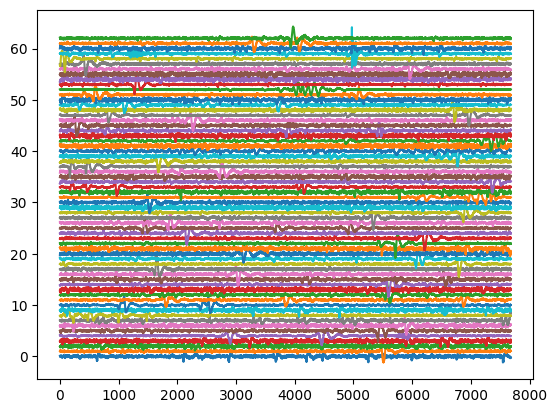

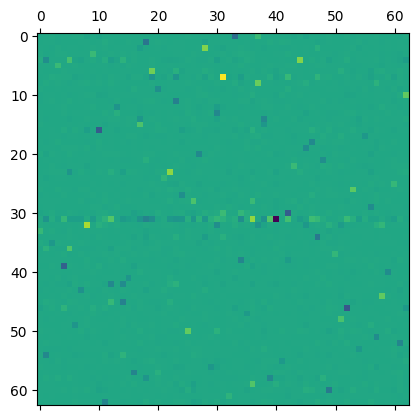

In [13]:
# X_1, X_2
n_components = 63
S = Y_1.std(axis = 0)
ica = FastICA(n_components=n_components)
S_ = ica.fit_transform(Y_1.T)
A_ = ica.mixing_

# assert np.allclose(Y_1, np.dot(S_, A_.T) + ica.mean_, atol = 1)

# pca = PCA(n_components=3)
# H = pca.fit_transform(X_1)

S_
models = [S_]
names = ['Plot 1' ,'Plot 2', 'Plot 3', 'Plot 4']
colors = ['grey', 'pink', 'brown', 'purple', 'red', 'green', 'orange']

offset = np.arange(S_.shape[1])[np.newaxis,:]
plt.plot(0.2*zscore(S_)+offset)
plt.matshow(A_)

# plt.plot(S_+offset)
# plt.xlim(0, 5000)



(7680, 63)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=63
  warnings.warn(


ValueError: For X (1026) and Y (7681) with flat shading, A should have shape (7680, 1025, 3) or (7680, 1025, 4) or (7680, 1025) or (7872000,), not (7680, 1025, 1)

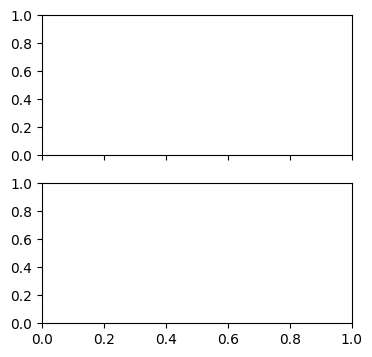

In [14]:
make_specgram([S_, A_], sfreq, ['Mixing Matrix', 'Demixing Matrix'])

Create Power Spectral Density graph for decomposed signals

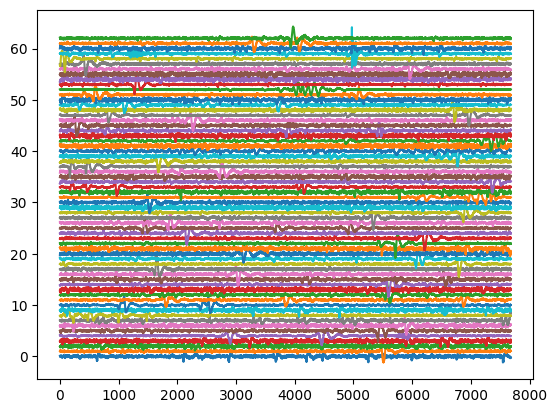

In [15]:
w = np.linalg.pinv(ica.mixing_)
y_hat = (w@Y_1).T
# plt.matshow(w)
offset = np.arange(y_hat.shape[1])[np.newaxis,:]
plt.plot(0.2*zscore(y_hat)+offset)
# plt.matshow(A_)


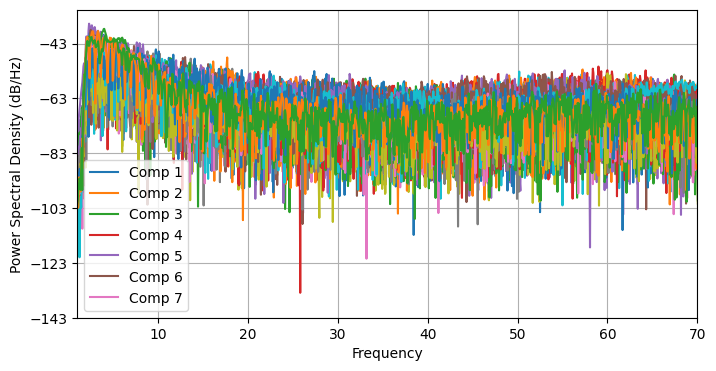

In [16]:
NFFT = int(2*4096)  # the length of the windowing segments


fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(8,4))
window_length_real_time = 14.5
n_samples = int(sfreq * window_length_real_time)

# Select a portion of S_ with the correct number of samples for PSD calculation
for i in range(n_components):
  signal_for_psd = S_[:n_samples, i] # Select the first component of the ICA output
  # mne.viz.plot_topomap(S_[0, :], info)
  ax.psd(signal_for_psd, NFFT=NFFT, Fs=sfreq, noverlap=int(NFFT/2))
  X_ICA = S_[:,i]
  # make_specgram([X_ICA], sfreq, ['ICA'])
# ax.psd(x_2[n_time], NFFT=NFFT, Fs=sfreq, noverlap=int(NFFT/2))
  # ax.set_xscale('log')
  # mne.viz.plot_topomap(X_ICA, info)
ax.legend(('Comp 1','Comp 2', 'Comp 3', 'Comp 4', 'Comp 5', 'Comp 6', 'Comp 7'))
plt.xlim(1, 70)
plt.show()

Plot topomaps

In [17]:
S_.shape

(7680, 63)

In [18]:
# X_ICA.shape
Y_1.shape
Y_1[:,0].shape

(63,)

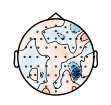

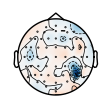

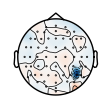

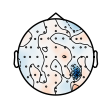

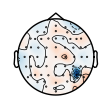

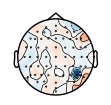

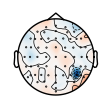

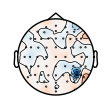

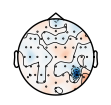

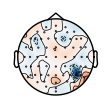

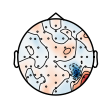

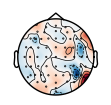

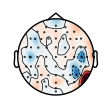

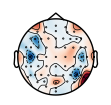

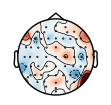

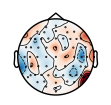

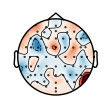

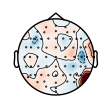

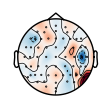

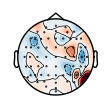

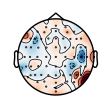

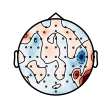

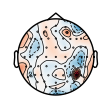

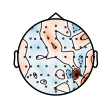

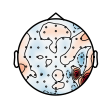

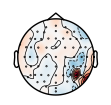

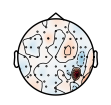

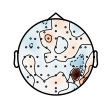

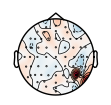

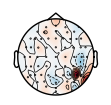

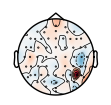

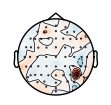

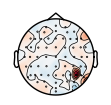

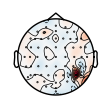

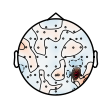

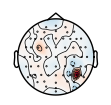

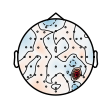

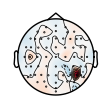

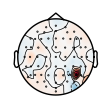

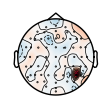

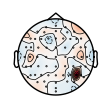

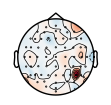

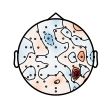

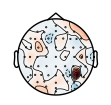

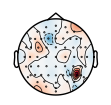

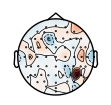

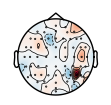

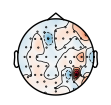

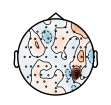

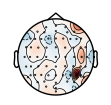

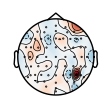

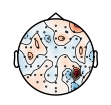

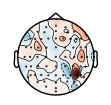

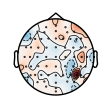

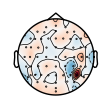

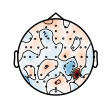

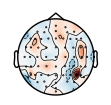

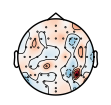

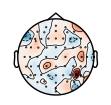

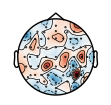

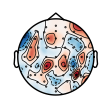

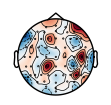

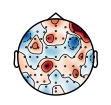

In [22]:
# info = mne.create_info(63, sfreq, ch_types='eeg')
# info.set_montage('biosemi256')
info = mne.create_info(63, sfreq, ch_types='eeg')

# Get the channel names from the biosemi256 montage
biosemi256_montage = mne.channels.make_standard_montage('biosemi64')
biosemi256_channel_names = biosemi256_montage.ch_names

# Select the first 63 channel names to match your data
relevant_channel_names = biosemi256_channel_names[:63]

# Rename the channels in your info object
mapping = {str(i): name for i, name in enumerate(relevant_channel_names)}
info.rename_channels(mapping)

# Now you can set the montage
info.set_montage('biosemi64')
for j in range(n_components):
    mne.viz.plot_topomap(S_[j, :], info)